# 📊 AI Business Intelligence System

This notebook implements a clean Business Intelligence pipeline using AI-powered sentiment analysis and decision support systems.

## 🚀 System Architecture
1. **Data Load & Cleaning**
2. **AI Sentiment Engine** (Overall & Aspect-Based)
3. **Conflict Detection** (Rating vs Sentiment)
4. **Explainable AI** (Reason Extraction)
5. **Business Metric Analysis**
6. **Risk Index Monitoring**
7. **Dashboard Visualization**
8. **Recommendation Engine**

In [1]:
# Core Imports
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ML & NLP Imports
import torch
from transformers import pipeline

# Configuration
plt.style.use("ggplot")
tqdm.pandas()

print("✅ System Dependencies Loaded")

2026-02-13 16:20:39.064961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770999639.455775      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770999639.565001      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770999640.430330      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770999640.430365      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770999640.430372      55 computation_placer.cc:177] computation placer alr

✅ System Dependencies Loaded


## 1️⃣ Load & Clean Data

In [2]:
# Load Dataset
df = pd.read_csv("/kaggle/input/dhaka/dhaka_restaurants.csv")

# Data Cleaning
df_cleaned = df.dropna(subset=["review_text"])

# Ensure review_text is string
df_cleaned = df_cleaned[
    df_cleaned["review_text"].apply(lambda x: isinstance(x, str))
]

# Text Preprocessing (Strip whitespace, normalize spaces)
df_cleaned["review_text"] = (
    df_cleaned["review_text"]
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
)

print(f"✅ Data Loaded & Cleaned. Total Rows: {len(df_cleaned)}")
df_cleaned.head(3)

✅ Data Loaded & Cleaned. Total Rows: 988


,business_name,business_address,business_phone,business_website,business_rating,business_total_reviews,reviewer_name,review_rating,review_date,review_text,review_additional_info
0,Izumi Japanese Kitchen,"House 24 C, Rd 119, Dhaka 1212, Bangladesh",+880 1933-446677,https://m.facebook.com/izumiBD/,4.5,2233,"{'name': 'Raunak Maskay', 'thumbnail': 'https:...",5.0,a month ago,"Izumi Japanese Kitchen in Gulshan, Dhaka is on...",NaN
1,Izumi Japanese Kitchen,"House 24 C, Rd 119, Dhaka 1212, Bangladesh",+880 1933-446677,https://m.facebook.com/izumiBD/,4.5,2233,"{'name': 'Dewan Asif', 'thumbnail': 'https://l...",5.0,4 months ago,Izumi Japanese Kitchen is a great place for re...,NaN
2,Izumi Japanese Kitchen,"House 24 C, Rd 119, Dhaka 1212, Bangladesh",+880 1933-446677,https://m.facebook.com/izumiBD/,4.5,2233,"{'name': 'Dr. Mehruba Mona', 'thumbnail': 'htt...",5.0,Edited 8 months ago,One of the authentic Japanese restaurant in Dh...,NaN


## 2️⃣ AI Sentiment Engine
Loads the sentiment analysis model and computes overall sentiment for each review.

In [3]:
# Load Sentiment Model
sentiment_model = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    device=0 if torch.cuda.is_available() else -1
)

print("✅ Sentiment Model Loaded")

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


✅ Sentiment Model Loaded


In [4]:
def get_overall_sentiment(text):
    try:
        # Truncate to 512 chars for model limit
        result = sentiment_model(text[:512])[0]
        return result["label"], result["score"]
    except:
        return "UNKNOWN", 0.0

# Apply Sentiment Analysis
print("⏳ Processing Overall Sentiment...")
df_cleaned[["overall_sentiment", "confidence"]] = (
    df_cleaned["review_text"]
    .progress_apply(lambda x: pd.Series(get_overall_sentiment(x)))
)

print("✅ Overall Sentiment Analysis Complete")
df_cleaned["overall_sentiment"].value_counts()

⏳ Processing Overall Sentiment...


100%|██████████| 988/988 [00:10<00:00, 97.26it/s] 

✅ Overall Sentiment Analysis Complete


overall_sentiment
positive    736
negative    213
neutral      39
Name: count, dtype: int64

## 3️⃣ Aspect-Based Sentiment Analysis
Analyzes specific business aspects: **Food, Service, Price, Ambience**.

In [5]:
ASPECTS = {
    "food": ["food", "taste", "meal", "burger", "pizza", "খাবার"],
    "service": ["service", "staff", "waiter", "manager", "সার্ভিস"],
    "price": ["price", "cost", "expensive", "cheap", "দাম"],
    "ambience": ["ambience", "environment", "atmosphere", "পরিবেশ"]
}

def aspect_sentiment(text, overall_label):
    text_lower = text.lower()
    result = {}

    for aspect, keywords in ASPECTS.items():
        if any(k in text_lower for k in keywords):
            result[aspect] = overall_label
        else:
            result[aspect] = None

    return result

print("⏳ Processing Aspect Sentiment...")
aspect_df = df_cleaned.progress_apply(
    lambda row: pd.Series(
        aspect_sentiment(
            row["review_text"],
            row["overall_sentiment"]
        )
    ),
    axis=1
)

df_cleaned = pd.concat([df_cleaned, aspect_df], axis=1)
print("✅ Aspect Analysis Complete")
df_cleaned.head(3)

⏳ Processing Aspect Sentiment...


100%|██████████| 988/988 [00:00<00:00, 6179.39it/s]

✅ Aspect Analysis Complete


,business_name,business_address,business_phone,business_website,business_rating,business_total_reviews,reviewer_name,review_rating,review_date,review_text,review_additional_info,overall_sentiment,confidence,food,service,price,ambience
0,Izumi Japanese Kitchen,"House 24 C, Rd 119, Dhaka 1212, Bangladesh",+880 1933-446677,https://m.facebook.com/izumiBD/,4.5,2233,"{'name': 'Raunak Maskay', 'thumbnail': 'https:...",5.0,a month ago,"Izumi Japanese Kitchen in Gulshan, Dhaka is on...",NaN,positive,0.711482,positive,positive,positive,positive
1,Izumi Japanese Kitchen,"House 24 C, Rd 119, Dhaka 1212, Bangladesh",+880 1933-446677,https://m.facebook.com/izumiBD/,4.5,2233,"{'name': 'Dewan Asif', 'thumbnail': 'https://l...",5.0,4 months ago,Izumi Japanese Kitchen is a great place for re...,NaN,positive,0.396864,positive,None,positive,None
2,Izumi Japanese Kitchen,"House 24 C, Rd 119, Dhaka 1212, Bangladesh",+880 1933-446677,https://m.facebook.com/izumiBD/,4.5,2233,"{'name': 'Dr. Mehruba Mona', 'thumbnail': 'htt...",5.0,Edited 8 months ago,One of the authentic Japanese restaurant in Dh...,NaN,positive,0.880845,positive,positive,None,positive


## 4️⃣ Conflict Detection (Reputation Risk Monitor)
Identifies discrepancies between user ratings and text sentiment (e.g., "Hidden Dissatisfaction").

In [6]:
def detect_conflict(row):
    rating = row.get("review_rating", 0)
    sentiment = row.get("overall_sentiment")

    if rating >= 4 and sentiment == "negative":
        return "Hidden Dissatisfaction" # High rating but negative text

    if rating <= 2 and sentiment == "positive":
        return "Politeness Bias" # Low rating but positive text

    if rating == 3 and sentiment in ["positive", "negative"]:
        return "Ambiguous Experience" # Mid rating with strong sentiment

    return "No Conflict"

df_cleaned["rating_sentiment_conflict"] = df_cleaned.apply(
    detect_conflict,
    axis=1
)

df_cleaned["rating_sentiment_conflict"].value_counts()

rating_sentiment_conflict
No Conflict               810
Ambiguous Experience       87
Hidden Dissatisfaction     82
Politeness Bias             9
Name: count, dtype: int64

## 5️⃣ Explainable AI (Reason Extraction)
Extracts specific reasons for negative sentiment using trigger words.

In [7]:
NEGATIVE_TRIGGERS = [
    "late", "rude", "slow", "bad", "cold", "delay",
    "খারাপ", "দেরি", "ঠান্ডা", "রুড"
]

def extract_reason(text):
    if not isinstance(text, str):
        return ""

    text_lower = text.lower()
    reasons = [w for w in NEGATIVE_TRIGGERS if w in text_lower]

    return ", ".join(reasons[:3]) if reasons else "Implicit dissatisfaction"

df_cleaned["explanation"] = df_cleaned.apply(
    lambda x: extract_reason(x["review_text"])
    if x["overall_sentiment"] == "negative"
    else "",
    axis=1
)

print("✅ Reason Extraction Complete")
df_cleaned[df_cleaned["overall_sentiment"] == "negative"][
    ["review_text", "explanation"]
].head()

✅ Reason Extraction Complete


,review_text,explanation
22,Cozy 5 star environment but the diversity of f...,Implicit dissatisfaction
28,"Not how you get reviews for a restaurant, I ho...",Implicit dissatisfaction
37,The atmosphere of this place and the service i...,Implicit dissatisfaction
51,The food is excellent. The candle light dinner...,Implicit dissatisfaction
56,"Let me start with the good things, their food....",late


## 6️⃣ Theme Insight & Business Metrics
Aggregating insights to understand key business drivers.

In [8]:
theme_summary = (
    df_cleaned[df_cleaned["overall_sentiment"] == "negative"]
    .groupby("explanation")
    .size()
    .sort_values(ascending=False)
    .head(10)
)

print("🔎 KEY BUSINESS INSIGHTS\n")

print("Top Negative Drivers:")
for reason, count in theme_summary.items():
    print(f"- {reason}: {count} reviews")

# Calculate Conflict Rate
conflict_rate = (
    (df_cleaned["rating_sentiment_conflict"] != "No Conflict").mean() * 100
)

# Calculate Risk Index
df_cleaned["risk_flag"] = df_cleaned["rating_sentiment_conflict"] != "No Conflict"
risk_rate = df_cleaned["risk_flag"].mean() * 100

print(f"\n⚠ Rating-Sentiment Conflict Rate: {conflict_rate:.2f}%")
print(f"⚠ Reputation Risk Index: {risk_rate:.2f}%")

🔎 KEY BUSINESS INSIGHTS

Top Negative Drivers:
- Implicit dissatisfaction: 146 reviews
- bad: 29 reviews
- late: 11 reviews
- cold: 8 reviews
- slow: 6 reviews
- bad, cold: 3 reviews
- delay: 2 reviews
- slow, bad: 2 reviews
- late, cold: 2 reviews
- late, rude, bad: 1 reviews

⚠ Rating-Sentiment Conflict Rate: 18.02%
⚠ Reputation Risk Index: 18.02%


In [9]:
print("📊 BUSINESS PERFORMANCE SUMMARY\n")

total_reviews = len(df_cleaned)
positive_rate = (df_cleaned["overall_sentiment"] == "positive").mean() * 100
negative_rate = (df_cleaned["overall_sentiment"] == "negative").mean() * 100
neutral_rate = (df_cleaned["overall_sentiment"] == "neutral").mean() * 100

print(f"Total Reviews: {total_reviews}")
print(f"Positive Rate: {positive_rate:.2f}%")
print(f"Negative Rate: {negative_rate:.2f}%")
print(f"Neutral Rate: {neutral_rate:.2f}%")

print("\n📍 AREA-WISE PERFORMANCE (Bottom 5)\n")
area_summary = (
    df_cleaned.groupby("business_address")["overall_sentiment"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0) * 100
)

print(area_summary.sort_values("negative", ascending=False).head(5))

📊 BUSINESS PERFORMANCE SUMMARY

Total Reviews: 988
Positive Rate: 74.49%
Negative Rate: 21.56%
Neutral Rate: 3.95%

📍 AREA-WISE PERFORMANCE (Bottom 5)

overall_sentiment                                   negative  neutral  \
business_address                                                        
Begum Rokeya Avenue, Opposite IDB Bhaban, Q9HJ+...      87.5      0.0   
7th Floor) Holding No. 3, Sultan Mansion, Begum...      62.5      0.0   
House 23 Rd 99, Dhaka 1212, Bangladesh                  62.5      0.0   
House No 42, Block- E, Road No 12, Banani, Dhak...      62.5      0.0   
Shop - 1, National School Market, Mirpur- 2, Dh...      62.5      0.0   

overall_sentiment                                   positive  
business_address                                              
Begum Rokeya Avenue, Opposite IDB Bhaban, Q9HJ+...      12.5  
7th Floor) Holding No. 3, Sultan Mansion, Begum...      37.5  
House 23 Rd 99, Dhaka 1212, Bangladesh                  37.5  
House No 42, Block- E

## 7️⃣ Visual Dashboard
Visualizing the insights for quick decision making.

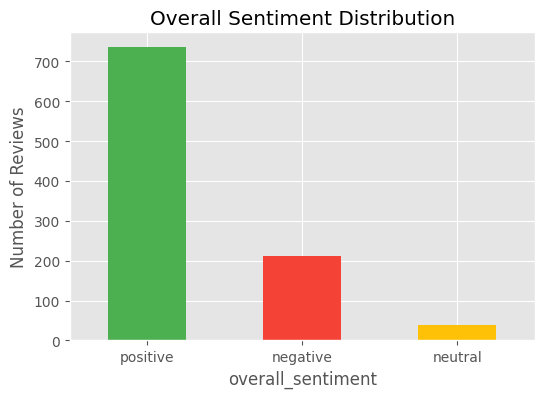

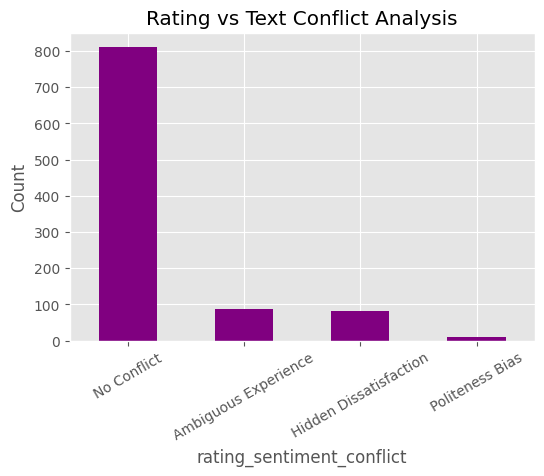

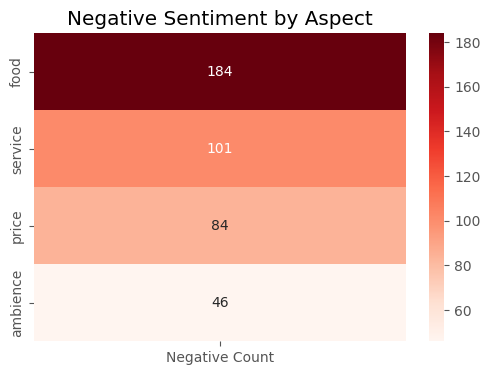

In [10]:
# -------------------------
# 1. Overall Sentiment Distribution
# -------------------------
plt.figure(figsize=(6,4))
df_cleaned["overall_sentiment"].value_counts().plot(kind="bar", color=['#4CAF50', '#F44336', '#FFC107'])
plt.title("Overall Sentiment Distribution")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.show()

# -------------------------
# 2. Rating vs Sentiment Conflict
# -------------------------
plt.figure(figsize=(6,4))
df_cleaned["rating_sentiment_conflict"].value_counts().plot(kind="bar", color='purple')
plt.title("Rating vs Text Conflict Analysis")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

# -------------------------
# 3. Aspect Sentiment Heatmap
# -------------------------
aspect_columns = ["food", "service", "price", "ambience"]
aspect_summary = {}

for col in aspect_columns:
    aspect_summary[col] = (
        df_cleaned[col].value_counts().get("negative", 0)
    )

aspect_df_viz = pd.DataFrame.from_dict(
    aspect_summary, orient="index", columns=["Negative Count"]
)

plt.figure(figsize=(6,4))
sns.heatmap(aspect_df_viz, annot=True, cmap="Reds", fmt='g')
plt.title("Negative Sentiment by Aspect")
plt.show()

## 8️⃣ Recommendation Engine
Final Logic to generate strategic recommendations based on the AI analysis.

In [11]:
print("🧠 AI BUSINESS RECOMMENDATION ENGINE\n")

# Determine Problem Areas
most_problematic_aspect = aspect_df_viz["Negative Count"].idxmax()
problem_count = aspect_df_viz["Negative Count"].max()

print(f"⚠️ Most Problematic Area: {most_problematic_aspect.upper()} ({problem_count} negative mentions)\n")
print(f"⚠️ Rating-Sentiment Conflict Rate: {conflict_rate:.2f}%\n")

# Generate Recommendations
recommendations = []

if most_problematic_aspect == "service":
    recommendations.append("🔴 URGENT: Improve staff training and customer handling.")
    
if most_problematic_aspect == "food":
    recommendations.append("🔴 URGENT: Review food quality control and taste consistency.")
    
if most_problematic_aspect == "price":
    recommendations.append("🟠 STRATEGY: Reevaluate pricing strategy or improve value perception.")
    
if most_problematic_aspect == "ambience":
    recommendations.append("🟠 UPGRADE: Enhance restaurant atmosphere and cleanliness.")

if conflict_rate > 15:
    recommendations.append("⚠ RISK: High level of hidden dissatisfaction. Investigate rating manipulation or politeness bias.")

print("📌 Strategic Recommended Actions:\n")
for rec in recommendations:
    print(f"- {rec}")

🧠 AI BUSINESS RECOMMENDATION ENGINE

⚠️ Most Problematic Area: FOOD (184 negative mentions)

⚠️ Rating-Sentiment Conflict Rate: 18.02%

📌 Strategic Recommended Actions:

- 🔴 URGENT: Review food quality control and taste consistency.
- ⚠ RISK: High level of hidden dissatisfaction. Investigate rating manipulation or politeness bias.


In [12]:
print("\n🤖 EXECUTIVE SUMMARY & ACTION PLAN\n")

most_issue = theme_summary.idxmax()

print(f"Most Critical Specific Complaints: '{most_issue}'")

print("\nFinal Decision Support:")
if risk_rate < 10:
    print("✅ Business Health: STABLE. Focus on maintaining quality.")
elif risk_rate < 20:
    print("⚠ Business Health: AT RISK. Address the negative drivers immediately.")
else:
    print("🚨 Business Health: CRITICAL. Immediate intervention required in Service/Food quality.")


🤖 EXECUTIVE SUMMARY & ACTION PLAN

Most Critical Specific Complaints: 'Implicit dissatisfaction'

Final Decision Support:
⚠ Business Health: AT RISK. Address the negative drivers immediately.
